<a href="https://colab.research.google.com/github/coco-in-bluemoon/three-minute-deep-learning-keras/blob/main/notebook/chapter7_2_gan_cnn_mnist_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


In [2]:
from keras import backend as K
from keras import layers, models, optimizers
import numpy as np
import tensorflow as tf

In [3]:
def mse_4d(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=(1, 2, 3))

def mse_4d_tf(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true), axis=(1, 2, 3))

In [4]:
class GAN(models.Sequential):
    def __init__(self, input_dim=64):

        super(GAN, self).__init__()

        self.input_dim = input_dim

        self.generator = self.GENERATOR()
        self.discriminator = self.DISCRIMINATOR()

        self.add(self.generator)
        self.discriminator.trainable = False
        self.add(self.discriminator)

        self.compile_all()

    def compile_all(self):
        # d_optimizer = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)
        # g_optimizer = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)
        d_optimizer = optimizers.Adam(lr=0.0001)
        g_optimizer = optimizers.Adam(lr=0.0001)

        self.generator.compile(loss=mse_4d_tf, optimizer='adam')
        self.compile(loss='binary_crossentropy', optimizer=g_optimizer)
        self.discriminator.trainable = True
        self.discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer)

    def GENERATOR(self):
        input_dim = self.input_dim

        model = models.Sequential()
        model.add(
            layers.Dense(1024, activation='tanh', input_dim=input_dim)
        )
        model.add(
            layers.Dense(7*7*128, activation='tanh')
        )
        model.add(
            layers.BatchNormalization()
        )
        model.add(
            layers.Reshape((7, 7, 128), input_shape=(7*7*128,))
        )
        assert model.output_shape == (None, 7, 7, 128)
        
        model.add(
            layers.UpSampling2D(size=(2, 2))
        )
        assert model.output_shape == (None, 14, 14, 128)

        model.add(
            layers.Conv2D(64, (5, 5), padding='same', activation='tanh')
        )
        model.add(
            layers.UpSampling2D(size=(2, 2))
        )
        assert model.output_shape == (None, 28, 28, 64)
        model.add(
            layers.Conv2D(1, (5, 5), padding='same', activation='tanh')
        )
        assert model.output_shape == (None, 28, 28, 1)

        return model

    def DISCRIMINATOR(self):
        model = models.Sequential()

        model.add(
            layers.Conv2D(64, (5, 5), padding='same', activation='tanh')
        )
        model.add(
            layers.MaxPooling2D(pool_size=(2, 2))
        )
        model.add(
            layers.Conv2D(128, (5, 5), activation='tanh')
        )
        model.add(
            layers.MaxPooling2D(pool_size=(2, 2))
        )
        model.add(
            layers.Flatten()
        )
        model.add(
            layers.Dense(1024, activation='tanh')
        )
        model.add(
            layers.Dense(1, activation='sigmoid')
        )

        return model

    def get_z(self, ln):
        input_dim = self.input_dim
        return np.random.uniform(-1, 1, (ln, input_dim))

    def train_both(self, x):
        ln = x.shape[0]

        z = self.get_z(ln)
        w = self.generator.predict(z, verbose=0)
        xw = np.concatenate((x, w))
        y2 = np.array([1] * ln + [0] * ln)

        d_loss = self.discriminator.train_on_batch(xw, y2)

        z = self.get_z(ln)
        self.discriminator.trainable = False
        g_loss = self.train_on_batch(z, np.array([1] * ln))
        self.discriminator.trainable = True

        return d_loss, g_loss

In [5]:

from PIL import Image
import math
import os
from keras.datasets import mnist

import matplotlib.pyplot as plt

In [6]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[1:3]

    image = np.zeros((height * shape[0], width * shape[1]), dtype=generated_images.dtype)

    for index, img in enumerate(generated_images):
        i = index // width
        j = index % width

        img = img.reshape(shape)
        image[i*shape[0]:(i+1)*shape[0],j*shape[1]:(j+1)*shape[1]] = img

    return image

def get_x(X_train, index, BATCH_SIZE):
    return X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]

def save_images(generated_images, output_fold, epoch, index):
    image = combine_images(generated_images)
    image = (image * 127.5) + 127.5
    Image.fromarray(image.astype(np.uint8)).save(f'{output_fold}/{str(epoch)}_{str(index)}.png')
    return image

def load_data(n_train):
    (X_train, y_train), (_, _) = mnist.load_data()
    return X_train[:n_train]

def train(args=None):
    if args:
        BATCH_SIZE = args.batch_size
        epochs = args.epochs
        output_fold = args.output_fold
        input_dim = args.input_dim
        n_train = args.n_train
    else:
        BATCH_SIZE = 16
        epochs = 1000
        output_fold = 'GAN_OUT'
        input_dim = 10
        n_train = 32


    os.makedirs(output_fold, exist_ok=True)
    print('output_fold is', output_fold)

    X_train = load_data(n_train)

    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape + (1, ))

    gan = GAN(input_dim)

    d_loss_ll = []
    g_loss_ll = []
    for epoch in range(epochs):
        # print('Epoch is', epoch)
        # print('Number of batches', int(X_train.shape[0] / BATCH_SIZE))

        d_loss_l = []
        g_loss_l = []

        for index in range(int(X_train.shape[0] / BATCH_SIZE)):
            x = get_x(X_train, index, BATCH_SIZE)

            d_loss, g_loss = gan.train_both(x)

            d_loss_l.append(d_loss)
            g_loss_l.append(g_loss)

            if (epoch % 10 == 0) or (epoch == epochs - 1):
                print('Epoch is', epoch)
                z = gan.get_z(x.shape[0])
                w = gan.generator.predict(z, verbose=0)

                image = save_images(w, output_fold, epoch, 0)
                if (epoch == 0) or (epoch == epochs - 1):
                    plt.imshow(image)
                    plt.show()

        d_loss_ll.append(d_loss_l)
        g_loss_ll.append(g_loss_l)

    gan.generator.save_weights(f'{output_fold}/generator', True)
    gan.discriminator.save_weights(f'{output_fold}/discriminator', True)

    np.savetxt(f'{output_fold}/d_loss', d_loss_ll)
    np.savetxt(f'{output_fold}/g_loss', g_loss_ll)

In [7]:
import argparse

In [8]:
def main():
    # parser = argparse.ArgumentParser()

    # parser.add_argument('--batch_size', type=int, default=16, help='Batch size for the networks')
    # parser.add_argument('--epochs', type=int, default=1000, help='Epochs for the networks')
    # parser.add_argument('--output_fold', type=str, default='GAN_OUT', help='Output fold to save the results')
    # parser.add_argument('--input_dim', type=int, default=10, help='Input dimension for the generator')
    # parser.add_argument('--n_train', type=int, default=32, help='The number of training data')

    # args = parser.parse_args()

    # train(args)
    train()

output_fold is GAN_OUT
Epoch is 0


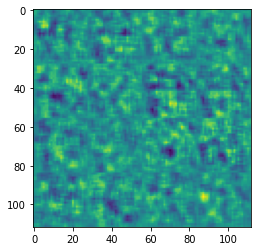

Epoch is 0


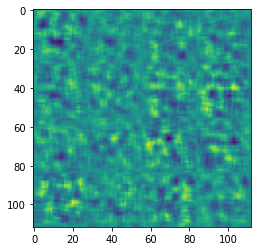

Epoch is 10
Epoch is 10
Epoch is 20
Epoch is 20
Epoch is 30
Epoch is 30
Epoch is 40
Epoch is 40
Epoch is 50
Epoch is 50
Epoch is 60
Epoch is 60
Epoch is 70
Epoch is 70
Epoch is 80
Epoch is 80
Epoch is 90
Epoch is 90
Epoch is 100
Epoch is 100
Epoch is 110
Epoch is 110
Epoch is 120
Epoch is 120
Epoch is 130
Epoch is 130
Epoch is 140
Epoch is 140
Epoch is 150
Epoch is 150
Epoch is 160
Epoch is 160
Epoch is 170
Epoch is 170
Epoch is 180
Epoch is 180
Epoch is 190
Epoch is 190
Epoch is 200
Epoch is 200
Epoch is 210
Epoch is 210
Epoch is 220
Epoch is 220
Epoch is 230
Epoch is 230
Epoch is 240
Epoch is 240
Epoch is 250
Epoch is 250
Epoch is 260
Epoch is 260
Epoch is 270
Epoch is 270
Epoch is 280
Epoch is 280
Epoch is 290
Epoch is 290
Epoch is 300
Epoch is 300
Epoch is 310
Epoch is 310
Epoch is 320
Epoch is 320
Epoch is 330
Epoch is 330
Epoch is 340
Epoch is 340
Epoch is 350
Epoch is 350
Epoch is 360
Epoch is 360
Epoch is 370
Epoch is 370
Epoch is 380
Epoch is 380
Epoch is 390
Epoch is 390
Epoc

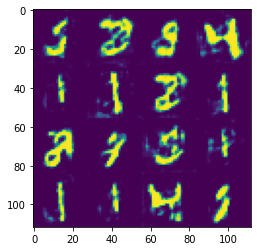

Epoch is 999


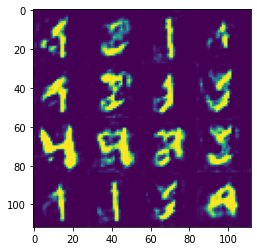

In [9]:
main()